<a href="https://colab.research.google.com/github/nht0017/HIDS/blob/main/CICIDS_multiclassipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from glob import glob
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix


## **Get Data from Kaggle**

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d cicdataset/cicids2017

! unzip cicids2017.zip

Saving kaggle.json to kaggle.json
 95% 219M/230M [00:02<00:00, 93.2MB/s]
100% 230M/230M [00:02<00:00, 109MB/s] 
Archive:  cicids2017.zip
  inflating: MachineLearningCSV.md5  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv  


# **Data Process**

In [ ]:
# Get a list of files from this dir
files_list = os.listdir('MachineLearningCSV/MachineLearningCVE/')

files_list.sort()

files_list

['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 'Friday-WorkingHours-Morning.pcap_ISCX.csv',
 'Monday-WorkingHours.pcap_ISCX.csv',
 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 'Tuesday-WorkingHours.pcap_ISCX.csv',
 'Wednesday-workingHours.pcap_ISCX.csv']

## **Read in Data**

Enter INDEX number within files_list to read in that dataframe

In [ ]:
INDEX =  4#@param {type:"integer"}

# Get df name
DATA = files_list[INDEX].split('.', 1)[0]
print('DATA:', DATA)
# Read in df
df = pd.read_csv('MachineLearningCSV/MachineLearningCVE/'+str(files_list[INDEX]), sep=',', header=0, engine='python')

df

DATA: Thursday-WorkingHours-Afternoon-Infilteration


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,166,1,1,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,12048.192770,1.660000e+02,0.000000e+00,166,166,0,0.000000e+00,0.000000e+00,0,0,0,0.000,0.000000,0,0,0,0,0,0,32,32,6024.096386,6024.096386,0,0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,1,0.0,0.0,0.0,32,0,0,0,0,0,0,1,0,1,0,290,243,0,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
1,60148,83,1,2,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,36144.578310,4.150000e+01,1.060660e+01,49,34,0,0.000000e+00,0.000000e+00,0,0,49,49.000,0.000000,49,49,0,0,0,0,32,64,12048.192770,24096.385540,0,0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,2,0.0,0.0,0.0,32,0,0,0,0,0,0,1,0,2,0,243,290,0,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2,123,99947,1,1,48,48,48,48,48.0,0.0,48,48,48.0,0.0,9.605091e+02,20.010606,9.994700e+04,0.000000e+00,99947,99947,0,0.000000e+00,0.000000e+00,0,0,0,0.000,0.000000,0,0,0,0,0,0,40,40,10.005303,10.005303,48,48,48.0,0.0,0.0,0,0,0,0,0,0,0,0,1,72.0,48.0,48.0,40,0,0,0,0,0,0,1,48,1,48,-1,-1,0,40,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
3,123,37017,1,1,48,48,48,48,48.0,0.0,48,48,48.0,0.0,2.593403e+03,54.029230,3.701700e+04,0.000000e+00,37017,37017,0,0.000000e+00,0.000000e+00,0,0,0,0.000,0.000000,0,0,0,0,0,0,32,32,27.014615,27.014615,48,48,48.0,0.0,0.0,0,0,0,0,0,0,0,0,1,72.0,48.0,48.0,32,0,0,0,0,0,0,1,48,1,48,-1,-1,0,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
4,0,111161336,147,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,1.322402,7.613790e+05,2.539814e+06,13600000,0,111000000,7.613790e+05,2.539814e+06,13600000,0,0,0.000,0.000000,0,0,0,0,0,0,0,0,1.322402,0.000000,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,147,0,0,0,-1,-1,0,0,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288597,80,590930,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,3.384496,5.909300e+05,0.000000e+00,590930,590930,590930,5.909300e+05,0.000000e+00,590930,590930,0,0.000,0.000000,0,0,0,0,0,0,64,0,3.384496,0.000000,0,0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0.0,0.0,0.0,64,0,0,0,0,0,0,2,0,0,0,238,-1,0,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
288598,80,1187988,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,1.683519,1.187988e+06,0.000000e+00,1187988,1187988,1187988,1.187988e+06,0.000000e+00,1187988,1187988,0,0.000,0.000000,0,0,0,0,0,0,64,0,1.683519,0.000000,0,0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0.0,0.0,0.0,64,0,0,0,0,0,0,2,0,0,0,238,-1,0,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
288599,80,10,1,9,6,54,6,6,6.0,0.0,6,6,6.0,0.0,6.000000e+06,1000

In [ ]:
df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,288602.000000,2.886020e+05,288602.000000,288602.000000,2.886020e+05,2.886020e+05,288602.000000,288602.000000,288602.000000,288602.000000,288602.000000,288602.000000,288602.000000,288602.000000,2.885840e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,288602.000000,288602.0,288602.000000,288602.0,288602.000000,2.886020e+05,2.886020e+05,2.886020e+05,288602.000000,288602.000000,288602.000000,288602.000000,2.886020e+05,288602.000000,288602.000000,288602.000000,288602.000000,288602.000000,288602.000000,288602.000000,288602.000000,288602.000000,288602.000000,288602.000000,288602.000000,288602.000000,288602.0,288602.0,288602.0,288602.0,288602.0,288602.0,288602.000000,2.886020e+05,288602.000000,2.886020e+05,288602.000000,288602.000000,288602.000000,288602.000000,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05
mean,8192.051115,8.974451e+06,6.229749,6.221596,5.662162e+02,6.162179e+03,140.848750,17.164105,41.673154,40.731899,325.969695,40.423188,133.065934,101.304279,inf,inf,6.027631e+05,1.072000e+06,3.047058e+06,7.451759e+04,8.725641e+06,1.263388e+06,8.494571e+05,2.941413e+06,7.116007e+05,8.223540e+06,1.245943e+06,6.619727e+05,2.571951e+06,7.598954e+05,0.036213,0.0,0.001091,0.0,162.484040,1.605226e+02,9.321699e+04,9.210731e+03,16.641132,362.783591,85.546570,107.554263,6.407230e+04,0.017256,0.036213,0.000270,0.406601,0.229115,0.085429,0.001091,0.000270,0.645318,96.936418,41.673154,133.065934,162.484040,0.0,0.0,0.0,0.0,0.0,0.0,6.229749,5.661134e+02,6.221596,6.162009e+03,5589.631212,1589.864855,3.435766,25.686859,6.137151e+04,4.154108e+04,1.325129e+05,3.810446e+04,2.609290e+06,1.210422e+05,2.701024e+06,2.484257e+06
std,17516.899862,2.753682e+07,74.587817,111.399547,2.605350e+04,1.897400e+05,435.712526,31.974350,118.941415,137.715423,757.749073,63.634968,270.640831,255.615376,NaN,NaN,3.221968e+06,4.639822e+06,1.129153e+07,2.003467e+06,2.739114e+07,7.455269e+06,3.188037e+06,1.126593e+07,7.227966e+06,2.667838e+07,7.588856e+06,2.923059e+06,1.076538e+07,7.346018e+06,0.186819,0.0,0.033019,0.0,2094.132799,3.119155e+03,2.881730e+05,4.121019e+04,22.764150,825.925261,173.851281,229.139064,2.084604e+05,0.130223,0.186819,0.016438,0.491200,0.420264,0.279520,0.033019,0.016438,0.686549,181.253543,118.941415,270.640831,2094.132799,0.0,0.0,0.0,0.0,0.0,0.0,74.587817,2.600262e+04,111.399547,1.897090e+05,13016.620266,7864.710940,49.746169,5.853203,5.195102e+05,3.778600e+05,9.265051e+05,4.408003e+05,1.068591e+07,1.637034e+06,1.099278e+07,1.051758e+07
min,0.000000,-2.000000

**Check for columns with only constant**

If Label only has 1 value, then we don't analyze this df.


In [ ]:
# Print a list of column containing only constant if exists
filt = np.std(df, axis=0) == 0

if filt.any == True:
  print(df.loc[:,filt])

Monday-WorkingHour only has normal class. Therefore, we do not run the algorithms on this dataset.


In [ ]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

## **Encoding Label**

In [ ]:
# Look for classes have < 2 instances --> drop it

filt = df[' Label'].value_counts() < 2

if filt.any == True: # If there is any class has < 2 instances
  for i in range(len(filt)):
    if filt[i]:
      #print(i)
      drop_class = filt[filt == True].index[i] # Assuming only 1 class has 1 instance
      print('A class with only 1 instance is ',drop_class)
      print('df shape before dropping:', df.shape)

      # Filter only classes that have only 1 instance and then drop it.
      class_filt = df[' Label'] == drop_class
      df.drop(index = df[class_filt].index , inplace=True) 
      print('df shape after dropping:', df.shape)
else:
  print('No Class < 2 instances')

No Class < 2 instances


In [ ]:
OG_labels = sorted( list(df[' Label'].unique() ))
print('Before encoding Label: ', OG_labels)
df[' Label'] = df[' Label'].astype("category").cat.codes

encoded_labels = sorted( list(df[' Label'].unique()))
print('After encoding Label: ', encoded_labels)

OG_y = df[' Label'] 
n_classes = len(OG_y.unique())

Before encoding Label:  ['BENIGN', 'Infiltration']
After encoding Label:  [0, 1]


In [ ]:
labels_dict = dict(zip(encoded_labels, OG_labels))
labels_dict

{0: 'BENIGN', 1: 'Infiltration'}

**Check if the df has infinity value**
if Yes, replace it with NaN value so that we can drop it altogether in a bit


In [ ]:
print('Has inf value?', np.any(np.isinf(df)))
if  np.any(np.isinf(df)):
  df.replace([np.inf, -np.inf], np.nan, inplace=True)

print('BEFORE removing NaN', df.shape)

# Removing NaN
df.dropna(axis=1, how='any', inplace=True)

print('AFTER removing NaN', df.shape)
print('Has NaN value?',np.any(np.isnan(df)))

Has inf value? True
BEFORE removing NaN (288602, 79)
AFTER removing NaN (288602, 77)
Has NaN value? False


## **Features Selection**

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2


r,c = df.shape
X = df.iloc[:,:c-1]
y = df[' Label']

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
best_features = featureScores.nlargest(30,'Score')
best_features  #print 30 best features

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [29 31 54 55 56 57 58 59] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,Specs,Score
66,act_data_pkt_fwd,10264.560445
61,Subflow Fwd Bytes,7736.679009
4,Total Length of Fwd Packets,7705.681239
2,Total Fwd Packets,4461.994645
60,Subflow Fwd Packets,4461.994645
32,Fwd Header Length,2238.371065
53,Fwd Header Length.1,2238.371065
68,Active Mean,2141.306005
3,Total Backward Packets,1980.473756
62,Subflow Bwd Packets,1980.473756


In [ ]:
# Enter SCORE as a lower limit to choose features
SCORE =  500#@param {type:"integer"}
best_column_indices = []

# Choose any features with scores above 1000
for index, row in best_features.iterrows():
  print(row[ "Score"])
  if row[ "Score"] > SCORE :
    best_column_indices.append(index)

X = X.iloc[:, best_column_indices]

X 

10264.560444833947
7736.679008551594
7705.681238893706
4461.9946446629665
4461.9946446629665
2238.371064566389
2238.371064566389
2141.3060051773105
1980.4737564919874
1980.4737564919874
1452.0799407766292
1236.4437771458993
1102.9379295204997
1002.8613862367039
695.2938751501885
341.6403171070818
338.76334493975446
306.26123886520554
291.5796419446975
278.51041081511914
278.51041081511914
233.7691076911487
229.09075718047222
207.8324770406624
199.99959048232557
181.85503473522593
165.83549697340044
165.83549697340044
143.43888560710283
120.93860728180438


,act_data_pkt_fwd,Subflow Fwd Bytes,Total Length of Fwd Packets,Total Fwd Packets,Subflow Fwd Packets,Fwd Header Length,Fwd Header Length.1,Active Mean,Total Backward Packets,Subflow Bwd Packets,Active Min,Active Max,Idle Std,Bwd Header Length,Active Std
0,0,0,0,1,1,32,32,0.000,1,1,0,0,0.000,32,0.000
1,0,0,0,1,1,32,32,0.000,2,2,0,0,0.000,64,0.000
2,0,48,48,1,1,40,40,0.000,1,1,0,0,0.000,40,0.000
3,0,48,48,1,1,32,32,0.000,1,1,0,0,0.000,32,0.000
4,0,0,0,147,147,0,0,1753752.625,0,0,95,4822992,2657727.996,0,2123197.578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288597,0,0,0,2,2,64,64,0.000,0,0,0,0,0.000,0,0.000
288598,0,0,0,2,2,64,64,0.000,0,0,0,0,0.000,0,0.000
288599,0,6,6,1,1,20,20,0.000,9,9,0,0,0.000,180,0.000
288600,9,2370,2370,10,10,200,200,0.000,0,0,0,0,0.000,0,0.000


In [ ]:
X.describe()

,act_data_pkt_fwd,Subflow Fwd Bytes,Total Length of Fwd Packets,Total Fwd Packets,Subflow Fwd Packets,Fwd Header Length,Fwd Header Length.1,Active Mean,Total Backward Packets,Subflow Bwd Packets,Active Min,Active Max,Idle Std,Bwd Header Length,Active Std
count,288602.000000,2.886020e+05,2.886020e+05,288602.000000,288602.000000,288602.000000,288602.000000,2.886020e+05,288602.000000,288602.000000,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05,2.886020e+05
mean,3.435766,5.661134e+02,5.662162e+02,6.229749,6.229749,162.484040,162.484040,6.137151e+04,6.221596,6.221596,3.810446e+04,1.325129e+05,1.210422e+05,1.605226e+02,4.154108e+04
std,49.746169,2.600262e+04,2.605350e+04,74.587817,74.587817,2094.132799,2094.132799,5.195102e+05,111.399547,111.399547,4.408003e+05,9.265051e+05,1.637034e+06,3.119155e+03,3.778600e+05
min,0.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,4.000000e+00,4.000000e+00,2.000000,2.000000,40.000000,40.000000,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,0.000000e+00
50%,1.000000,4.900000e+01,4.900000e+01,2.000000,2.000000,48.000000,48.000000,0.000000e+00,2.000000,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+01,0.000000e+00
75%,1.000000,9.500000e+01,9.500000e+01,3.000000,3.000000,72.000000,72.000000,0.000000e+00,2.000000,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.400000e+01,0.000000e+00
max,9130.000000,1.287034e+07,1.290000e+07,22673.000000,22673.000000,742984.000000,742984.000000,6.520000e+07,44553.000000,44553.000000,6.520000e+07,7.910000e+07,7.530000e+07,1.425704e+06,3.810000e+07


## **Data Cleaning**

In [ ]:
label_range = np.arange(0, np.max(y.unique())+1)

label_range

array([0, 1])

Class 0 - BENIGN: n=288566 (99.988%)
---------> Major class 0
Class 1 - Infiltration: n=36 (0.012%)


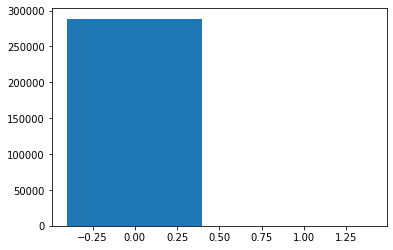

In [ ]:
from collections import Counter

sub_X = pd.DataFrame()
MAX_CASES = 1

# summarize distribution
counter = Counter(df[' Label'])
for k,v in counter.items():
  per = v / len(df[' Label']) * 100
  print('Class %s - %s: n=%d (%.3f%%)' % (k, labels_dict[k], v, per))
  if v > MAX_CASES:
    MAX_CASES = v
    biggest_class = k
    print('---------> Major class %d'% k)

# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Separating normal observations from intrusion ones. That way, if the dataset is imbalanced, we can easily bootstrap either class.

### **Removing duplicates from multiple classes**

- Separate each class into a df
- Remove duplicate rows that exist in multiple classes


In [ ]:
# Rename column to integers
X.set_axis(np.arange(0, len(X.columns)), axis=1, inplace=True)

# Filter out normal class and different attacks and put them in separate dfs
data = []
for label in encoded_labels:
  filt = y == label
  data.append( X.loc[filt] )
  
# condense data from each class into different sets
class_set = {}
index = 0
for item in data:
  #print(item)
  class_list = item.values.tolist()
  class_set[index] = set(tuple(i) for i in class_list)
  index += 1

# print original sets lengths
print( 'Before cleaning:')
for key, value in class_set.items():
  print( 'Class %d len: %d' % (key, len(value)) )

Before cleaning:
Class 0 len: 49955
Class 1 len: 35


**When take the difference between multiple sets like (A - B - C), the result contain only A rows that doesn't exist in B nor C**

In [ ]:
# Take the differences between 1 class and the others:
def difference_per_class ( class_number ):
  diff = class_set[class_number]
  for i in range(len(class_set)):
    # Normal class must be differentiated from all intrusion classes:
    #if class_number == NORMAL_CLASS_INDEX and i != class_number:
    #  diff -= class_set[i]
      #print('*************** NORMAL CLASS ALERT!!!!')
    #else:
      if i > class_number:
        diff -= class_set[i] 
  return diff

# Get the differences of all classes:
cleaned_class_set = {}
for key in class_set:
  cleaned_class_set[key] = difference_per_class(key)

print( 'After cleaning:')
MAX_CASES = 0
MAX_CLASS = 0
for key, value in cleaned_class_set.items():
  print( 'Class %d len: %d' % (key, len(value)) )
  if len(value) > MAX_CASES:
    MAX_CASES = len(value)
    MAX_CLASS = key

print('MAX CLASS %d has %d cases'% (MAX_CLASS, MAX_CASES))

After cleaning:
Class 0 len: 49954
Class 1 len: 35
MAX CLASS 0 has 49954 cases


In [ ]:
# Append data from minor classes into 1 dataframe sub_X
sub_X = pd.DataFrame()
for key in cleaned_class_set:
  if key != MAX_CLASS:
    data_per_class = pd.DataFrame(cleaned_class_set[key])
    data_per_class['Labels'] = np.ones( len(cleaned_class_set[key]), dtype=int )*key  # The label value is the key value
    sub_X = sub_X.append(data_per_class, ignore_index=True)

# Append data from major class into major_X
major_X = pd.DataFrame(cleaned_class_set[MAX_CLASS])
major_X['Labels'] = MAX_CLASS
major_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Labels
0,4.0,1115.0,1115.0,12.0,12.0,392.0,392.0,9.614800e+04,7.0,7.0,17805.0,174491.0,12232.947310,232.0,110793.73310,0
1,8.0,473.0,473.0,9.0,9.0,192.0,192.0,5.304300e+04,9.0,9.0,43864.0,89453.0,574.592290,252.0,20354.00773,0
2,8.0,1549.0,1549.0,9.0,9.0,192.0,192.0,0.000000e+00,8.0,8.0,0.0,0.0,0.000000,164.0,0.00000,0
3,5.0,696.0,696.0,6.0,6.0,132.0,132.0,0.000000e+00,7.0,7.0,0.0,0.0,0.000000,148.0,0.00000,0
4,4.0,1030.0,1030.0,40.0,40.0,1288.0,1288.0,3.570445e+04,49.0,49.0,22928.0,141707.0,9606.878405,1576.0,35405.73649,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49949,3.0,347.0,347.0,9.0,9.0,296.0,296.0,1.667330e+05,6.0,6.0,166733.0,166733.0,0.000000,200.0,0.00000,0
49950,12.0,786.0,786.0,13.0,13.0,272.0,272.0,1.210393e+05,15.0,15.0,87526.0,284763.0,223.698607,384.0,80211.61592,0
49951,17.0,1190.0,1190.0,18.0,18.0,372.0,372.0,2.963290e+05,18.0,18.0,87009.0,505649.0,239253.822100,372.0,296023.18290,0
49952,3.0,957.0,957.0,16.0,16.0,520.0,520.0,4.006567e+05,13.0,13.0,50526.0,2150792.0,421795.902100,424.0,857387.71650,0


In [ ]:
sub_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Labels
0,1818.0,489184.0,489184.0,1819.0,1819.0,36380.0,36380.0,5.863632e+06,1817.0,1817.0,809115.0,9355307.0,1.610000e+07,36340.0,4.482322e+06,1
1,3397.0,1645814.0,1645814.0,3398.0,3398.0,67972.0,67972.0,8.243630e+05,3398.0,3398.0,824363.0,824363.0,0.000000e+00,67972.0,0.000000e+00,1
2,3732.0,1827335.0,1827335.0,3733.0,3733.0,74660.0,74660.0,0.000000e+00,3732.0,3732.0,0.0,0.0,0.000000e+00,74640.0,0.000000e+00,1
3,503.0,171452.0,171452.0,504.0,504.0,10080.0,10080.0,2.190000e+07,504.0,504.0,21900000.0,21900000.0,0.000000e+00,10080.0,0.000000e+00,1
4,34.0,13418.0,13418.0,35.0,35.0,700.0,700.0,4.963369e+06,35.0,35.0,4963369.0,4963369.0,0.000000e+00,700.0,0.000000e+00,1
5,24.0,5821.0,5821.0,25.0,25.0,500.0,500.0,5.698800e+05,25.0,25.0,553425.0,582609.0,1.910000e+07,500.0,1.494452e+04,1
6,4.0,141.0,141.0,5.0,5.0,112.0,112.0,0.000000e+00,6.0,6.0,0.0,0.0,0.000000e+00,132.0,0.000000e+00,1
7,0.0,0.0,0.0,15.0,15.0,460.0,460.0,0.000000e+00,15.0,15.0,0.0,0.0,0.000000e+00,300.0,0.000000e+00,1
8,1.0,101.0,101.0,2.0,2.0,40.0,40.0,0.000000e+00,1.0,1.0,0.0,0.0,0.000000e+00,20.0,0.000000e+00,1
9,47.0,12042.0,12042.0,48.0,48.0,972.0,972.0,2.024844e+06,52.0,52.0,3051.0,7461188.0,1.020000e+07,1052.0,3.093999e+06,1


In [ ]:
# Append major_X into sub_X to create X w/o bootstrapping
X = sub_X.append(major_X)

# Reset index and then save Labels into y
X.reset_index(drop=True, inplace=True)
y = X['Labels']
X.drop(columns=['Labels'], inplace= True)

X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1818.0,489184.0,489184.0,1819.0,1819.0,36380.0,36380.0,5.863632e+06,1817.0,1817.0,809115.0,9355307.0,1.610000e+07,36340.0,4.482322e+06
1,3397.0,1645814.0,1645814.0,3398.0,3398.0,67972.0,67972.0,8.243630e+05,3398.0,3398.0,824363.0,824363.0,0.000000e+00,67972.0,0.000000e+00
2,3732.0,1827335.0,1827335.0,3733.0,3733.0,74660.0,74660.0,0.000000e+00,3732.0,3732.0,0.0,0.0,0.000000e+00,74640.0,0.000000e+00
3,503.0,171452.0,171452.0,504.0,504.0,10080.0,10080.0,2.190000e+07,504.0,504.0,21900000.0,21900000.0,0.000000e+00,10080.0,0.000000e+00
4,34.0,13418.0,13418.0,35.0,35.0,700.0,700.0,4.963369e+06,35.0,35.0,4963369.0,4963369.0,0.000000e+00,700.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49984,3.0,347.0,347.0,9.0,9.0,296.0,296.0,1.667330e+05,6.0,6.0,166733.0,166733.0,0.000000e+00,200.0,0.000000e+00
49985,12.0,786.0,786.0,13.0,13.0,272.0,272.0,1.210393e+05,15.0,15.0,87526.0,284763.0,2.236986e+02,384.0,8.021162e+04
49986,17.0,1190.0,1190.0,18.0,18.0,372.0,372.0,2.963290e+05,18.0,18.0,87009.0,505649.0,2.392538e+05,372.0,2.960232e+05
49987,3.0,957.0,957.0,16.0,16.0,520.0,520.0,4.006567e+05,13.0,13.0,50526.0,2150792.0,4.217959e+05,424.0,8.573877e+05


In [ ]:
y

0        1
1        1
2        1
3        1
4        1
        ..
49984    0
49985    0
49986    0
49987    0
49988    0
Name: Labels, Length: 49989, dtype: int64

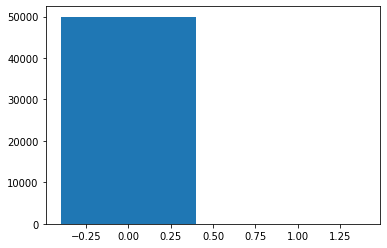

0    49954
1       35
Name: Labels, dtype: int64

In [ ]:
# summarize distribution
def print_dist(data):
  counter = Counter(data)
  # plot the distribution
  plt.bar(counter.keys(), counter.values())
  plt.show()

print_dist(y)
y.value_counts()

# **Data Partition**

In [ ]:
# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y) 

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((34992, 15), (34992,), (14997, 15), (14997,))

## **Oversample data**
 **Upsampling minor classes in training set to ensure the algs can learn from a balanced data**

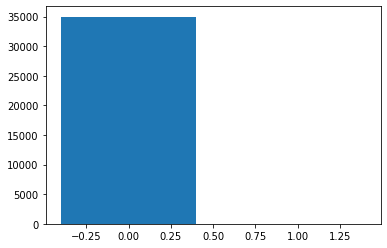

Max Class 0 has 34968 cases
Second Max Class len 24


Before upsampling minor classes: (24, 16)
After upsampling: (34968, 16) 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


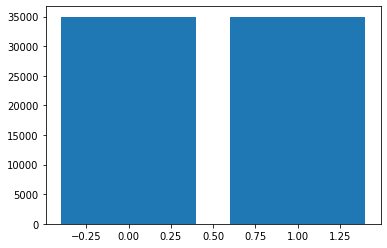

In [ ]:
def over_sample(data, label):
  print_dist(label)

  ## Make sure y_train is balanced by upsampling minor classes up to the second biggest class

  # Look for the second biggest class
  label_dist = label.value_counts()
  max = 0; max_class = 0; max_2, max_2_class = 0, 0
  for i in range(len(label_dist)):
    if label_dist[i] > max:
      max_2 = max
      max_2_class = max_class
      max = label_dist[i]
      max_class = i
    elif max_2 < label_dist[i] < max:
      max_2 = label_dist[i]
      max_2_class = i

  print('Max Class %d has %d cases\nSecond Max Class len %d' % (max_class, max, max_2) )

  # Upsample minor classes upto the second biggest class
  filt = label == max_class
  #filt2 = label == max_2_class
  #major_y_train = label.loc[filt].append(label.loc[filt2])
  major_y_train = label.loc[filt]
  major_train = data.loc[data.index.isin(major_y_train.index)]

  # get the complement of the major classes indices
  minor_train = data.loc[~data.index.isin(major_y_train.index)]
  # get minor labels
  minor_train['Labels'] = label.loc[label.index.isin(minor_train.index)]
  #df[~df.index.isin(df_a.index+df_b.index)]
  print('\n\nBefore upsampling minor classes:', minor_train.shape)

  minor_train = minor_train.groupby('Labels').sample(n = max, replace=True) 
  minor_y_train = minor_train['Labels']
  print('After upsampling:', minor_train.shape, '\n')

  data = major_train.append(minor_train.drop(columns='Labels'), ignore_index = True)
  label = major_y_train.append(minor_y_train, ignore_index=True )
  label.astype('int32')
  print_dist(label)

  return data, label

x_train, y_train = over_sample(x_train, y_train)
#x_test,  y_test  = over_sample(x_test, y_test)

In [ ]:
# Binarize y_train and y_test
from sklearn.preprocessing import label_binarize

# Binarize the output
if n_classes > 2:
  encoded_y_train = pd.DataFrame(label_binarize(y_train, classes = label_range))
  encoded_y_test  = pd.DataFrame(label_binarize(y_test, classes = label_range))
else:
  encoded_y_train = y_train
  encoded_y_test  = y_test

print('n_classes:', n_classes)

x_train.shape, encoded_y_train.shape, x_test.shape, encoded_y_test.shape

n_classes: 2


((69936, 15), (69936,), (14997, 15), (14997,))

In [ ]:
encoded_y_train

0        0
1        0
2        0
3        0
4        0
        ..
69931    1
69932    1
69933    1
69934    1
69935    1
Name: Labels, Length: 69936, dtype: int64

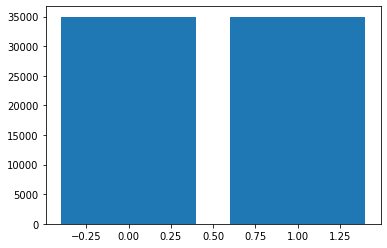

69936

In [ ]:
# plot the distribution
counter = Counter(y_train)

plt.bar(counter.keys(), counter.values())
plt.show()
len(y_train)

In [ ]:
print('TRAIN',y_train.value_counts())
class_w =  y_test.value_counts()
print('TEST', class_w)

TRAIN 1    34968
0    34968
Name: Labels, dtype: int64
TEST 0    14986
1       11
Name: Labels, dtype: int64


In [ ]:
class_w.to_list()

[14986, 11]


# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale
4.   Graphing overlaid ROC curves, where each one represents a model AUC score





In [ ]:
from itertools import cycle

# Plot all ROC curves
def plot_ROC (performance_measures, labels_dict, model_name):
  plt.figure(figsize=(10,6))
  fpr = performance_measures.get('fpr')
  tpr = performance_measures.get('tpr')
  roc_auc = performance_measures.get('auc')
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'green'])

  if n_classes > 2:
    plt.plot( fpr["micro"] , tpr["micro"], 
            label='micro-average (AUC = {0:0.4f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average (AUC = {0:0.4f})'.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='{0} (AUC = {1:0.4f})'
                ''.format(labels_dict[i], roc_auc[i]))
  else:
    plt.plot(fpr, tpr, lw=2,
                label='AUC = {0:0.4f}'.format(roc_auc))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC of multi-class using '+ model_name)
  plt.legend(loc="lower right",fancybox=True, shadow=True, ncol=2, fontsize = 10)
  plt.show()

def get_cmatrix(model_name ,true_labels, pred_labels):
  if n_classes <= 2:
    return confusion_matrix(true_labels, pred_labels)
  else:
    return confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels, label_names):
  # rows are actual, columns are predicted
  #cmatrix = confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  cmatrix = get_cmatrix(model_name, true_labels, pred_labels)

  print('Confusion Matrix: \n',cmatrix)
  print('\nClassification report:', classification_report(true_labels, pred_labels, target_names = label_names, zero_division=0), sep='\n')
  print('\nTesting Accuracy: %.2f'% accuracy_score(true_labels, pred_labels))
  print('Micro AUC: %.4f'% roc_auc_score(true_labels, pred_labels, average='micro', multi_class='ovr'))
  print('Macro AUC: %.4f'% roc_auc_score(true_labels, pred_labels, average='macro', multi_class='ovr'))

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix(model_name, true_labels, pred_labels, labels):
  plt.figure(figsize=(10,10))
  #cmatrix = confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  cmatrix = get_cmatrix(model_name, true_labels, pred_labels)
  rows, cols = cmatrix.shape

  plt.figure(figsize=(8,8))
  plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of '+ model_name)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=90)
  plt.yticks(tick_marks, labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('Actual Labels')
 
  large_vals = cmatrix.max()/2  #comment out because there are too many classes --> no need number
  for i in range(rows):
    for j in range(cols):
      if cmatrix[i, j] >= large_vals:
        color='white'
      else:
        color = 'black'
      plt.text(j, i, cmatrix[i, j], horizontalalignment = 'center', color= color)
  

## Record fpr, tpr and roc_auc info of each model on each class
def record_measures(true_labels, pred_labels):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  if n_classes > 2:
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels.iloc[:, i], pred_labels[:, i])  
        roc_auc[i] = auc(fpr[i], tpr[i])

        #if np.isnan( roc_auc[i] ):
        #  roc_auc[i] = 0.5
        print('ROC AUC Class ',i,':', roc_auc[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve( true_labels.to_numpy().reshape(-1), pred_labels.reshape(-1))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-avg ROC curve and area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    measures = {}
    measures['fpr'], measures['tpr'] = fpr, tpr
    measures['auc'] = roc_auc
    
  else:
    #print('Binary classification')
    measures = {}
    measures['fpr'], measures['tpr'], thresh = roc_curve(true_labels, pred_labels)
    measures['auc'] = auc(measures['fpr'], measures['tpr'])

  return measures
  

# Calculate either avg fpr or tpr given A DICT performance measurements of a model
# key_str can be: fpr, tpr, auc  ==== DEL
def get_ROC_info(info, key_str):
  fpr = info.get(key_str)
  fpr_arr = []
  for key in fpr:
    if key_str == 'auc':
      fpr_arr.append(fpr[key])
    elif key != 'micro' and key != 'macro':
      if len(fpr[key]) == 2: # incase some fpr only has [0, 1]
        #print('has < 2 elements', fpr[key], type(fpr[key]))
        fpr[key] = np.insert( fpr[key], 1, 0)
      fpr_arr.append(fpr[key])
    

  # Stack the fpr of each class on top of each other
  #print('get ROC info', key_str)
  #print(fpr_arr)
  fpr_arr = pd.DataFrame(np.row_stack(fpr_arr))

  # Get avg fpr
  return fpr_arr.mean().tolist()

# Save avg fpr, tpr and auc of a model to a dict ===== DEL
def combine_ROC_info(info):
  model_dict = {}
  model_dict['tpr'] = get_ROC_info(info, 'tpr')
  model_dict['fpr'] = get_ROC_info(info, 'fpr')
  model_dict['auc'] = get_ROC_info(info, 'auc')
  return model_dict


# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC (roc_type = 'micro'):
  # Set color for each model
  colors = {'DT': 'magenta','RF': 'green','KNN': 'darkturquoise', 'BERT': 'deeppink', 
            'GPT': 'deeppink', 'LGBM': 'lightcoral', 'XGB': 'blue'}
  # Set marker for each model          
  markers = { 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'BERT':'<--', 'GPT': '>--',
             'LGBM': '1--', 'XGB': '2--'}
  
  plt.figure(figsize=(9,6))
## need to get the average fpr and tpr of all class
  if n_classes > 2:
    DT_fpr = DT_test.get('fpr')[roc_type];    DT_tpr = DT_test.get('tpr')[roc_type]; DT_auc = DT_test.get('auc')[roc_type]
    #print(DT, DT_auc)
    RF_fpr = RF_test.get('fpr')[roc_type];    RF_tpr = RF_test.get('tpr')[roc_type];    RF_auc  = RF_test.get('auc')[roc_type]
    KNN_fpr = KNN_test.get('fpr')[roc_type];  KNN_tpr = KNN_test.get('tpr')[roc_type];  KNN_auc = KNN_test.get('auc')[roc_type]
    LGBM_fpr = LGBM_test.get('fpr')[roc_type];LGBM_tpr = LGBM_test.get('tpr')[roc_type];LGBM_auc= LGBM_test.get('auc')[roc_type]
    XGB_fpr = XGB_test.get('fpr')[roc_type];  XGB_tpr = XGB_test.get('tpr')[roc_type];  XGB_auc = XGB_test.get('auc')[roc_type]
    BERT_fpr = BERT_test.get('fpr')[roc_type];BERT_tpr = BERT_test.get('tpr')[roc_type];BERT_auc= BERT_test.get('auc')[roc_type]
  else:
    DT_fpr = DT_test.get('fpr');      DT_tpr = DT_test.get('tpr');    DT_auc = DT_test.get('auc')
    RF_fpr = RF_test.get('fpr');      RF_tpr = RF_test.get('tpr');    RF_auc = RF_test.get('auc')
    KNN_fpr = KNN_test.get('fpr');    KNN_tpr = KNN_test.get('tpr');  KNN_auc = KNN_test.get('auc')
    LGBM_fpr = LGBM_test.get('fpr');  LGBM_tpr = LGBM_test.get('tpr'); LGBM_auc = LGBM_test.get('auc')
    XGB_fpr = XGB_test.get('fpr');    XGB_tpr = XGB_test.get('tpr');  XGB_auc = XGB_test.get('auc')
    BERT_fpr = BERT_test.get('fpr');  BERT_tpr = BERT_test.get('tpr');BERT_auc = BERT_test.get('auc')

  plt.plot(DT_fpr, DT_tpr,   markers.get('DT'),  color=colors.get('DT'),  label="DT - AUC=" + str( round(DT_auc, 4) )) 
  plt.plot(RF_fpr,  RF_tpr,  markers.get('RF'),  color=colors.get('RF'),  label="RF - AUC=" + str( round(RF_auc, 4) ))
  plt.plot(KNN_fpr, KNN_tpr, markers.get('KNN'), color=colors.get('KNN'), label="KNN - AUC="+ str( round(KNN_auc, 4) ))
  plt.plot(LGBM_fpr,LGBM_tpr,markers.get('LGBM'),color=colors.get('LGBM'),label="LGBM - AUC=" +str( round(LGBM_auc, 4) ))
  plt.plot(XGB_fpr, XGB_tpr, markers.get('XGB'), color=colors.get('XGB'), label="XGB - AUC="+ str( round(XGB_auc,4) ))

  plt.plot(BERT_fpr, BERT_tpr, markers.get('BERT'), color=colors.get('BERT'),label="BERT - AUC="+ str( round(BERT_auc,4) ))
  #plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right',fontsize= 10) 
  plt.title( 'Testing '+ roc_type+' ROCs on ' + DATA)
  plt.show()

# **Decision Tree**


TESTING
Confusion Matrix: 
 [[14980     6]
 [    3     8]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     14986
Infiltration       0.57      0.73      0.64        11

    accuracy                           1.00     14997
   macro avg       0.79      0.86      0.82     14997
weighted avg       1.00      1.00      1.00     14997


Testing Accuracy: 1.00
Micro AUC: 0.8634
Macro AUC: 0.8634


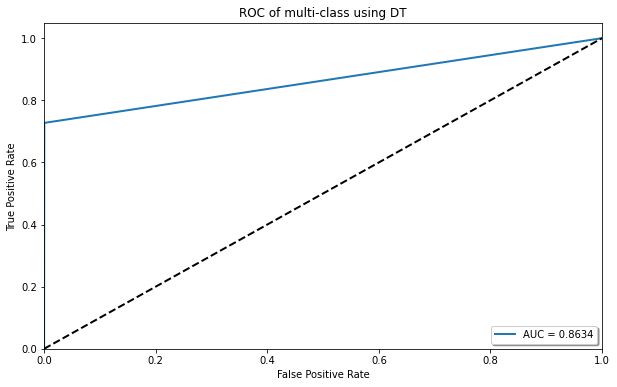

Train AUC: 0.9998 vs Test AUC: 0.8634


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto')
decTree = decTree.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = decTree.predict(x_train)
DT_train = record_measures(encoded_y_train, y_pred)


# Predict testing data
y_predicted = decTree.predict(x_test)

# Print performance measures
print('\nTESTING')
print_performance('Decision Tree', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
DT_test = record_measures(encoded_y_test, y_predicted)

# Print ROC Curve
plot_ROC(DT_test, labels_dict, 'DT')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(DT_train['auc']['macro'], DT_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc'], DT_test['auc']))



<Figure size 720x720 with 0 Axes>

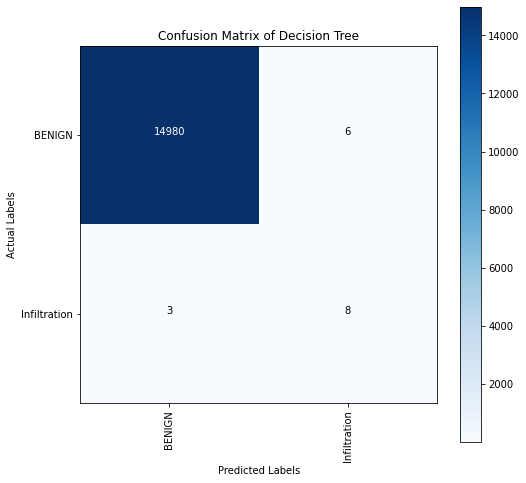

In [ ]:
# Color Confusion Matrix
color_confusion_matrix('Decision Tree', encoded_y_test, y_predicted, OG_labels)

# **Random Forest**


TESTING
Confusion Matrix: 
 [[14985     1]
 [    3     8]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     14986
Infiltration       0.89      0.73      0.80        11

    accuracy                           1.00     14997
   macro avg       0.94      0.86      0.90     14997
weighted avg       1.00      1.00      1.00     14997


Testing Accuracy: 1.00
Micro AUC: 0.8636
Macro AUC: 0.8636


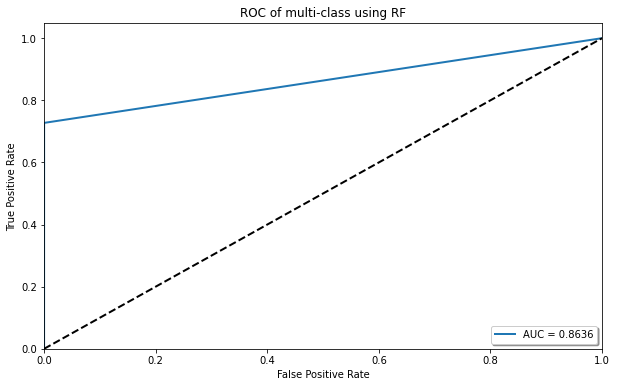

Train AUC: 0.9999 vs Test AUC: 0.8636


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=5, 
                                      max_features='auto', bootstrap=True,verbose=0, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = randomForest.predict(x_train)
RF_train = record_measures(encoded_y_train, y_pred)

# Predict the labels for testing set
y_predicted = randomForest.predict(x_test)

# Print performance measures
print('\nTESTING')
print_performance('Random Forest', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for the multi-ROC curves
RF_test = record_measures(encoded_y_test, y_predicted)

# Print ROC Curve
plot_ROC(RF_test, labels_dict, 'RF')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(RF_train['auc']['macro'], RF_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(RF_train['auc'], RF_test['auc']))


In [ ]:
RF_test

{'auc': 0.8636029991628551,
 'fpr': array([0.0000000e+00, 6.6728947e-05, 1.0000000e+00]),
 'tpr': array([0.        , 0.72727273, 1.        ])}

<Figure size 720x720 with 0 Axes>

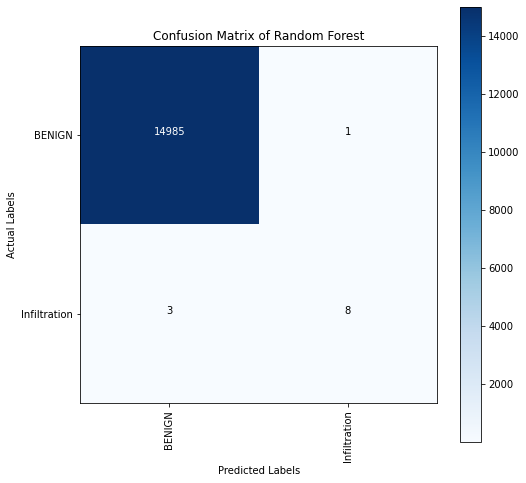

In [ ]:
# Color Confusion Matrix
color_confusion_matrix('Random Forest', encoded_y_test, y_predicted, OG_labels)

# **KNN**

Since KNN takes longer to classify this amount of data, we randomly sample 10K normal rows and 10K intrusion rows to train and test KNN.

Confusion Matrix: 
 [[14976    10]
 [    7     4]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     14986
Infiltration       0.29      0.36      0.32        11

    accuracy                           1.00     14997
   macro avg       0.64      0.68      0.66     14997
weighted avg       1.00      1.00      1.00     14997


Testing Accuracy: 1.00
Micro AUC: 0.6815
Macro AUC: 0.6815


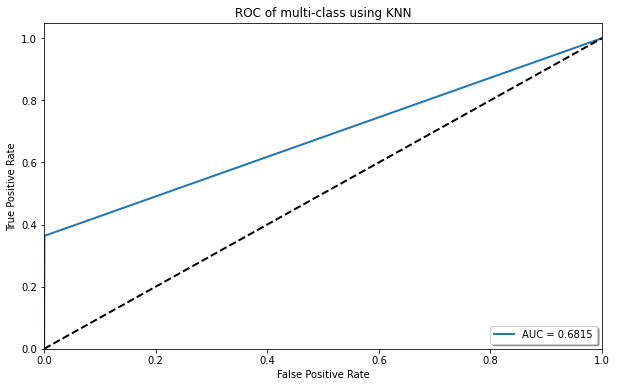

Train AUC: 0.9998 vs Test AUC: 0.6815


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=3, weights='uniform')
KNN.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = KNN.predict(x_train)
KNN_train = record_measures(encoded_y_train, y_pred)

# Predict testing data
y_predicted = KNN.predict(x_test)

# Print performance measures
print_performance('KNN', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
KNN_test = record_measures( encoded_y_test, y_predicted)

# Print ROC Curve
plot_ROC(KNN_test, labels_dict, 'KNN')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(KNN_train['auc']['macro'], KNN_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(KNN_train['auc'], KNN_test['auc']))

<Figure size 720x720 with 0 Axes>

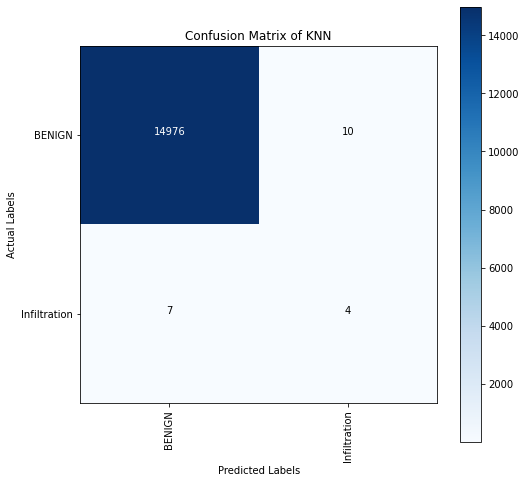

In [ ]:
# Color Confusion Matrix
color_confusion_matrix('KNN', encoded_y_test, y_predicted, OG_labels)

# **LightGBM**

Note: LightGBM can only be trained with labels 0,1,2,3,4,5, etc. not binarized labels

Confusion Matrix: 
 [[14985     1]
 [    4     7]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     14986
Infiltration       0.88      0.64      0.74        11

    accuracy                           1.00     14997
   macro avg       0.94      0.82      0.87     14997
weighted avg       1.00      1.00      1.00     14997


Testing Accuracy: 1.00
Micro AUC: 0.8181
Macro AUC: 0.8181


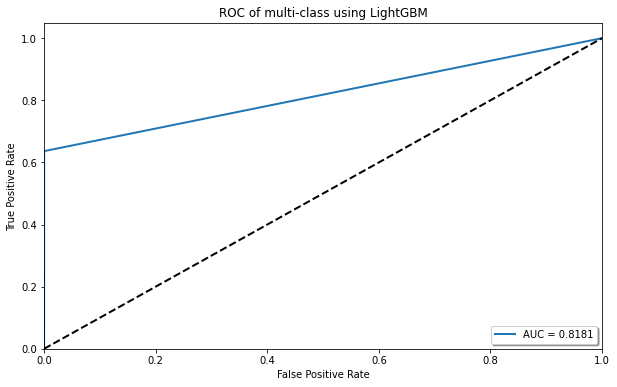

Train AUC: 1.0000 vs Test AUC: 0.8181


In [ ]:
from lightgbm import LGBMClassifier

# Train LightGBM Classifier
if n_classes > 2:
  lgbmc = LGBMClassifier(objective= 'multiclass')
 
  #y_pred = label_binarize(y_pred, classes= label_range)
else:
  lgbmc = LGBMClassifier(objective= 'binary')
  
lgbmc.fit(x_train, y_train)
y_pred = lgbmc.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_range)

# Recording TPR and FPR for TRAINING-ROC curves
LGBM_train = record_measures(encoded_y_train, y_pred)

# Predict test data
y_predicted = lgbmc.predict(x_test)

# Encode y_predicted:
y_pred_encoded = label_binarize(y_predicted, classes= label_range)

# Print performance measures
print_performance('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
LGBM_test = record_measures(encoded_y_test, y_pred_encoded)

# Print ROC Curve
plot_ROC(LGBM_test, labels_dict, 'LightGBM')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(LGBM_train['auc']['macro'], LGBM_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(LGBM_train['auc'], LGBM_test['auc']))

<Figure size 720x720 with 0 Axes>

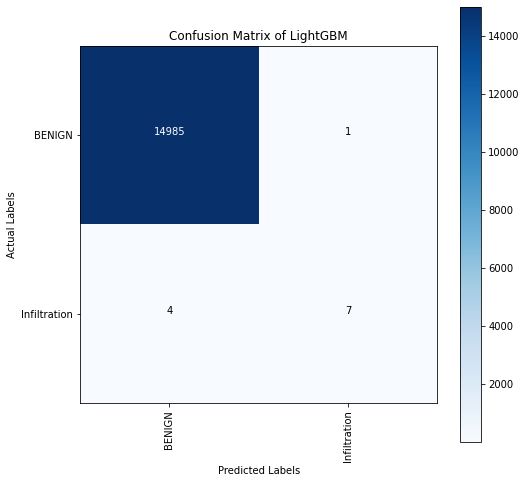

In [ ]:
# Color Confusion Matrix
color_confusion_matrix('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# **XGBoost**



Testing Result of XGBoost:
Confusion Matrix: 
 [[14940    46]
 [    3     8]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     14986
Infiltration       0.15      0.73      0.25        11

    accuracy                           1.00     14997
   macro avg       0.57      0.86      0.62     14997
weighted avg       1.00      1.00      1.00     14997


Testing Accuracy: 1.00
Micro AUC: 0.8621
Macro AUC: 0.8621


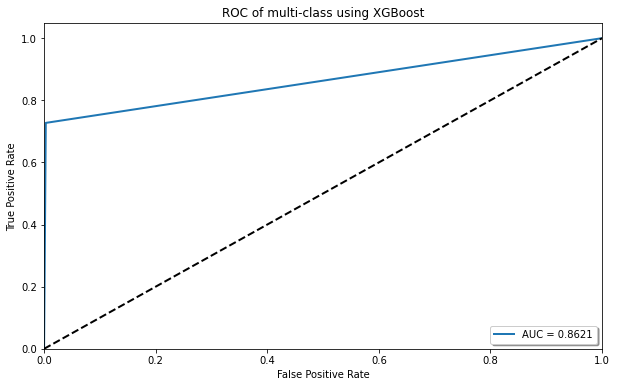

Train AUC: 0.9985 vs Test AUC: 0.8621


In [ ]:
from xgboost import XGBClassifier

# Train XGBoost Classifier
xgb = XGBClassifier(eval_metric="logloss")

xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_range)


# Recording TPR and FPR for TRAINING-ROC curves
XGB_train = record_measures(encoded_y_train, y_pred)

# Predict test data
y_predicted = xgb.predict(x_test)

# Encode y_predicted:
y_pred_encoded = label_binarize(y_predicted, classes= label_range)

# Print performance measures
print('\n\nTesting Result of XGBoost:')
print_performance('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
XGB_test = record_measures(encoded_y_test, y_pred_encoded)

# Print ROC Curve
plot_ROC(XGB_test, labels_dict, 'XGBoost')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(XGB_train['auc']['macro'], XGB_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(XGB_train['auc'],XGB_test['auc']))


<Figure size 720x720 with 0 Axes>

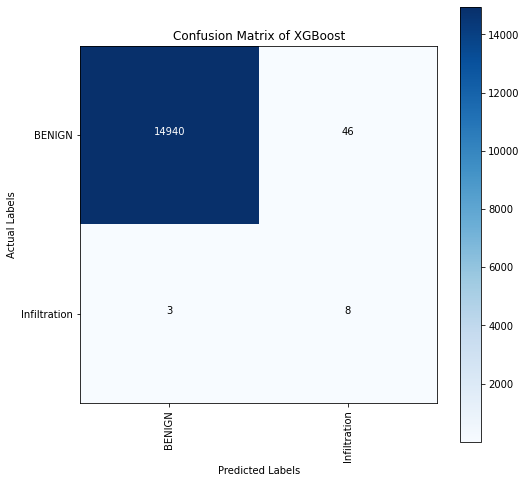

In [ ]:
# Color Confusion Matrix
color_confusion_matrix('XGBoost', encoded_y_test, y_pred_encoded, OG_labels)

 Ploting the overlaid ROC curves on testing results:
graph_multi_ROC()

graph_multi_ROC()

# **BERT**


# **Multi-class BERT**

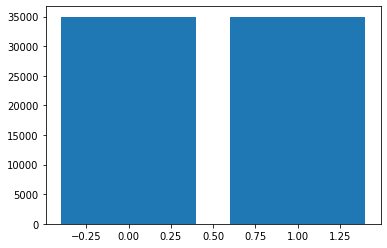

In [ ]:
# plot the distribution
counter = Counter(y_train)

plt.bar(counter.keys(), counter.values())
plt.show()

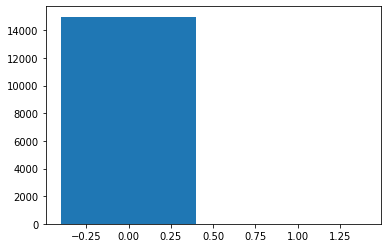

In [ ]:
# plot the distribution
counter = Counter(y_test)

plt.bar(counter.keys(), counter.values())
plt.show()

## **Combining all features into a sentence**

In [ ]:
y_train.value_counts()

1    34968
0    34968
Name: Labels, dtype: int64

train_data = x_train.append(y_train, ignore_index = False)
train_data
#print(len(x_sub), len(y_sub))

In [ ]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 


In [ ]:
train_texts

('7.0 378.0 378.0 8.0 8.0 172.0 172.0 0.0 6.0 6.0 0.0 0.0 0.0 132.0 0.0',
 '3.0 120.0 120.0 4.0 4.0 128.0 128.0 0.0 4.0 4.0 0.0 0.0 0.0 128.0 0.0',
 '3.0 6344.0 6344.0 18.0 18.0 584.0 584.0 613649.75 17.0 17.0 57242.0 4507616.0 6941.03011 552.0 1573399.97',
 '63.0 1402.0 1402.0 64.0 64.0 1292.0 1292.0 65313.181820000005 78.0 78.0 28432.0 429861.0 7031.459201000001 1704.0 120909.6342',
 '18.0 2237.0 2237.0 20.0 20.0 424.0 424.0 60169.72727 19.0 19.0 34411.0 315670.0 41129.47312 520.0 84739.9393',
 '3.0 2542.0 2542.0 4.0 4.0 92.0 92.0 0.0 5.0 5.0 0.0 0.0 0.0 112.0 0.0',
 '9.0 324.0 324.0 10.0 10.0 212.0 212.0 152769.3333 10.0 10.0 102168.0 405091.0 79996.02629 284.0 123611.898',
 '3.0 1817.0 1817.0 7.0 7.0 232.0 232.0 0.0 6.0 6.0 0.0 0.0 0.0 200.0 0.0',
 '255.0 11842.0 11842.0 256.0 256.0 5128.0 5128.0 2501856.0 451.0 451.0 212770.0 4790942.0 13800000.0 9028.0 3237256.4669999997',
 '5.0 324.0 324.0 6.0 6.0 120.0 120.0 0.0 2.0 2.0 0.0 0.0 0.0 40.0 0.0',
 '1.0 437.0 437.0 4.0 4.0 136.0 136

In [ ]:
test_texts = []
for i in range(x_test.shape[0]):
     test_texts.append(" ".join(np.array(x_test.iloc[i,:]).astype(str)))
test_texts = tuple(test_texts)

In [ ]:
encoded_y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: Labels, dtype: int64

In [ ]:
!pip install transformers

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [ ]:
### --------- Setup BERT ---------- ###
# Name of the BERT model to use
model_name = 'bert-base-uncased'
# Max length of tokens
if len(X.columns) > 30:
  max_length = 50
elif 20<= len(X.columns) <= 30:
  max_length =  40
elif 10 < len(X.columns) < 20:
  max_length = 30
else:
  max_length = 9 # for the rest of the datasets

if INDEX == 2:
  max_length = 6 # for dataset index 2

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
### ------- Build the model ------- ###

# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
label = Dense(units=len(label_range), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='label')(pooled_output)
#product = Dense(units=len(data.Product_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='product')(pooled_output)
outputs = {'label': label}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 30)]              0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
label (Dense)                (None, 2)                 1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = {'label': CategoricalCrossentropy(from_logits = True)}
metric = {'label': CategoricalAccuracy('accuracy')}

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Ready output data for the model
if n_classes == 2:
  encoded_labels = to_categorical(encoded_y_train)
else:
  encoded_labels = encoded_y_train

# Tokenize the input (takes some time)
x = tokenizer(
    text= list(train_texts),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y={'label': encoded_labels},
    validation_split=0.2,
    batch_size=128,
    epochs = 2)

Epoch 1/2
 72/438 [===>..........................] - ETA: 4:14 - loss: 0.1484 - accuracy: 0.9362

In [ ]:
y_train_pred = model.predict(x={'input_ids': x['input_ids']}, verbose = 1)

y_train_pred_encoded = label_binarize(y_train_pred['label'].argmax(axis=1), classes= label_range)

# Recording TPR and FPR for TRAINING-ROC curves
if n_classes > 2:
  BERT_train = record_measures( encoded_y_train, y_train_pred_encoded) 
else:
  BERT_train = record_measures( y_train, y_train_pred_encoded) 

In [ ]:
### ----- Evaluate the model ------ ###

# Ready test data
if n_classes == 2:
  encoded_test_labels = to_categorical(encoded_y_test)
else:
  encoded_test_labels = encoded_y_test

test_x = tokenizer(
    text= list(test_texts),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'label': encoded_test_labels}
)

In [ ]:
y_predicted = model.predict( x={'input_ids': test_x['input_ids']}, verbose=1 )

# Encode y_predicted: ***************************
y_pred_encoded = label_binarize(y_predicted['label'].argmax(axis=1), classes= label_range)
#y_pred_encoded, encoded_y_test

In [ ]:
# Print performance measures
if n_classes > 2:
  print_performance('BERT', encoded_y_test, y_pred_encoded, OG_labels)
  BERT_test = record_measures( encoded_y_test, y_pred_encoded)    # Recording TPR and FPR for TESTING-ROC curves
else:
  print_performance('BERT', y_test, y_pred_encoded, OG_labels)
  BERT_test = record_measures( y_test, y_pred_encoded)            # Recording TPR and FPR for TESTING-ROC curves

# Print ROC Curve
plot_ROC(BERT_test, labels_dict, 'BERT')


if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(BERT_train['auc']['macro'], BERT_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(BERT_train['auc'],BERT_test['auc']))

In [ ]:
# Color Confusion Matrix
if n_classes > 2:
  color_confusion_matrix('BERT', encoded_y_test, y_pred_encoded, OG_labels)
else:
  color_confusion_matrix('BERT', y_test, y_pred_encoded, OG_labels)


# **GPT-2**

In [ ]:
BERT_test

# **Graphing multi-ROC Curves**

In [ ]:
# Ploting the overlaid ROC curves on testing results:
# Graph micro AUC
graph_multi_ROC()

# Graph macro AUC
graph_multi_ROC('macro')

# **NOTE After Preventing Overfitting**
**No need to scale data because BERT doesn't work well with that**

0 - Friday-WorkingHours-Afternoon-DDos: has 30 col features and 2 classes. Intrusion class is dominant in this dataset and it is nearly balanced with over 127K DDoS instances and over 84K normal instances. As a result, all algorithms perform very well with AUC above 0.999, except KNN 0.985. Also, all algorithms except KNN achieves 1 in accuracy, precision, recall and Macro F1-Score.

1 - Friday-WorkingHours-Afternoon-PortScan: has 30 col features and 2 classes. This dataset has no overlap records between 2 classes. There are almost 116K normal instances along with almost 2K PortScan instances. All algs perform very well with AUC above 0.98.

2 - Friday-WorkingHours-Morning: has 3 col features and 2 classes. This dataset is not so imbalanced. There are 1936 unique intrusion instances and over 160K normal instances. The algs perform well (AUC above 0.92 except BERT 0.82). 

3 - Monday: Only contains normal class, so we did not analyze it.

4 - Thursday-WorkingHours-Afternoon-Infilteration: has 13 col features and 2 classes. All multiclass classifiers perform poorly (AUC below 0.60 except XGB 0.74). This is due to lack of unique intrusion instances. There are almost 50K normal instances and only 35 unique intrusion instances. 

5 - Thursday-WorkingHours-Morning-WebAttacks: has 3 col features and 4 classes and all multiclass classifiers perform adequately (AUC around 0.70). All algs misclassified Brute Force for XSS because they have very similar values in the best features. This is also because this dataset is extremely imbalance, where each intrusion class only has 22 unique instances or less and normal class has over 16K instances. After splitting, the test set only contains 13 instances from all intrusion classes while it contains 5058 normal instances.

6 - Tuesday Working Hour: has 3 classes and all multiclass classifiers (including BERT) perform very well (AUC above 0.96). Normal data are dominant in this dataset (over 180K), while intrusion classes (FTP and SSH) have 626 cases amd 140 cases respectively. Therefore, the performance is really good comparing to the other imbalanced dataset.

7 - Wednesday Working Hour: has 5 classes and all classifiers (except BERT since we ran out of RAM while running BERT) perform very well (AUC above 0.99). This dataset is not too imbalanced. Each intrusion class has more than 5000 distinctive instances except heartbleed, which only has 11 instances.

